# Feature-based Ranking (Learning to Rank)

Цель:
- построить модель ранжирования с признаками (feature-based),
  которая предсказывает, какие товары пользователь купит;
- использовать историю взаимодействий (train) как источник фич;
- обучать модель на валидaционной части (val) и оценивать на test
  по `precision@k` и `recall@k`.


In [2]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier

# если precision_recall_at_k у тебя уже есть в другом ноуте — можно просто копировать оттуда
from typing import Iterable, Set, Tuple

def precision_recall_at_k(
    recommended: Iterable[int],
    relevant: Set[int],
    k: int,
) -> tuple[float, float]:
    if k == 0:
        return 0.0, 0.0

    rec_k = list(recommended)[:k]
    rec_set = set(rec_k)

    hit_count = len(rec_set & relevant)
    precision = hit_count / k
    recall = hit_count / len(relevant) if relevant else 0.0

    return precision, recall

# Загружаем уже подготовленные сплиты
train = pd.read_csv("../data/processed/train.csv")
val = pd.read_csv("../data/processed/val.csv")
test = pd.read_csv("../data/processed/test.csv")

for df in (train, val, test):
    df["timestamp"] = pd.to_datetime(df["timestamp"])

train.shape, val.shape, test.shape


((1008982, 5), (126123, 5), (126123, 5))

In [3]:
# Веса для implicit feedback
event_weight = {
    "view": 1.0,
    "addtocart": 2.0,
    "transaction": 3.0,
}

for df in (train, val, test):
    df["weight"] = df["event"].map(event_weight)

# История (history) для фич — только train
history = train.copy()

# Популярность товара в истории
item_pop = (
    history
    .groupby("itemid")
    .size()
    .rename("item_pop")
)

# Активность пользователя в истории
user_act = (
    history
    .groupby("visitorid")
    .size()
    .rename("user_activity")
)

# Статистика по паре (user, item) в истории
ui_stats = (
    history
    .groupby(["visitorid", "itemid"])
    .agg(
        ui_interactions=("event", "size"),
        ui_max_weight=("weight", "max"),
    )
    .reset_index()
)

item_pop.head(), user_act.head(), ui_stats.head()


(itemid
 6     11
 15    15
 16     8
 19     6
 25    32
 Name: item_pop, dtype: int64,
 visitorid
 2     8
 7     3
 23    3
 37    8
 60    3
 Name: user_activity, dtype: int64,
    visitorid  itemid  ui_interactions  ui_max_weight
 0          2  216305                2            1.0
 1          2  259884                1            1.0
 2          2  325215                3            1.0
 3          2  342816                2            1.0
 4          7  139394                1            1.0)

In [7]:
def build_rank_dataset(history_df, label_df, neg_per_pos: int = 5, seed: int = 42) -> pd.DataFrame:
    """
    history_df: df с историей взаимодействий (для фич)
    label_df: df, в котором покупки считаем таргетом (обычно val или test)
    neg_per_pos: сколько негативных примеров генерировать на один позитив
    """
    rng = np.random.default_rng(seed)

    # Берём только покупки как таргет
    label_trans = label_df[label_df["event"] == "transaction"].copy()
    if label_trans.empty:
        raise ValueError("label_df не содержит ни одной транзакции.")

    # Популярность товаров и активность пользователей считаем по истории
    item_pop = (
        history_df
        .groupby("itemid")
        .size()
        .rename("item_pop")
    )

    user_act = (
        history_df
        .groupby("visitorid")
        .size()
        .rename("user_activity")
    )

    ui_stats = (
        history_df
        .groupby(["visitorid", "itemid"])
        .agg(
            ui_interactions=("event", "size"),
            ui_max_weight=("weight", "max"),
        )
        .reset_index()
    )

    # Список популярных товаров (для выборки негативов)
    popular_items = item_pop.sort_values(ascending=False).index.tolist()

    rows = []

    # Строим датасет по пользователям с покупками в label_df
    for user_id, user_labels in label_trans.groupby("visitorid"):
        pos_items = set(user_labels["itemid"])

        # если пользователь вообще не встречается в истории — пропускаем
        if user_id not in user_act.index:
            continue

        # Негативы — random популярные, которых пользователь не купил в label
        num_negs = max(len(pos_items) * neg_per_pos, 10)
        neg_items = []
        tries = 0
        while len(neg_items) < num_negs and tries < num_negs * 10:
            item = popular_items[rng.integers(0, len(popular_items))]
            if item not in pos_items:
                neg_items.append(item)
            tries += 1

        cand_items = list(pos_items) + neg_items

        for item_id in cand_items:
            label = int(item_id in pos_items)
            rows.append(
                {
                    "visitorid": user_id,
                    "itemid": item_id,
                    "label": label,
                }
            )

    df_rank = pd.DataFrame(rows)

    # Присоединяем фичи
    df_rank = df_rank.merge(item_pop.reset_index(), on="itemid", how="left")
    df_rank = df_rank.merge(user_act.reset_index(), on="visitorid", how="left")
    df_rank = df_rank.merge(ui_stats, on=["visitorid", "itemid"], how="left")

    # Заполняем пропуски нулями
    df_rank[["item_pop", "user_activity", "ui_interactions", "ui_max_weight"]] = (
        df_rank[["item_pop", "user_activity", "ui_interactions", "ui_max_weight"]]
        .fillna(0.0)
    )

    return df_rank   # <--- вот этого не хватало


In [8]:
train_rank = build_rank_dataset(history_df=train, label_df=val, neg_per_pos=5)
train_rank["split"] = "train"

history_tv = pd.concat([train, val], ignore_index=True)
test_rank = build_rank_dataset(history_df=history_tv, label_df=test, neg_per_pos=5)
test_rank["split"] = "test"

train_rank.shape, test_rank.shape, train_rank["label"].mean(), test_rank["label"].mean()


((5149, 8),
 (5023, 8),
 np.float64(0.14255195183530783),
 np.float64(0.14294246466255225))

In [9]:
features = ["item_pop", "user_activity", "ui_interactions", "ui_max_weight"]

X_train = train_rank[features]
y_train = train_rank["label"]

rf_ranker = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    random_state=42,
    n_jobs=-1,
)

rf_ranker.fit(X_train, y_train)


,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",200
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",10
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric(y

In [10]:
def evaluate_rank_model(df_rank: pd.DataFrame, scores: np.ndarray, ks=(5, 10, 20)) -> pd.DataFrame:
    df = df_rank.copy()
    df["score"] = scores

    rows = []

    for k in ks:
        precisions = []
        recalls = []

        for user_id, group in df.groupby("visitorid"):
            # релевантные товары (покупки)
            rel_items = set(group.loc[group["label"] == 1, "itemid"])
            if not rel_items:
                continue

            group_sorted = group.sort_values("score", ascending=False)
            rec_items = group_sorted["itemid"].iloc[:k].tolist()

            p, r = precision_recall_at_k(rec_items, rel_items, k)
            precisions.append(p)
            recalls.append(r)

        rows.append(
            {
                "k": k,
                "precision@k": np.mean(precisions) if precisions else 0.0,
                "recall@k": np.mean(recalls) if recalls else 0.0,
            }
        )

    return pd.DataFrame(rows)


In [11]:
X_test = test_rank[features]
y_test = test_rank["label"]

test_scores = rf_ranker.predict_proba(X_test)[:, 1]

rank_results = evaluate_rank_model(test_rank, test_scores, ks=(5, 10, 20))
rank_results


,k,precision@k,recall@k
0,5,0.259633,0.764388
1,10,0.169266,0.923929
2,20,0.101147,0.957397


## Выводы по feature-based ranking

В этом ноутбуке была реализована модель ранжирования с признаками
(feature-based ranking) для задачи рекомендаций товаров.

В отличие от классических collaborative filtering подходов, модель
обучается предсказывать релевантность пары (user, item) на основе
агрегированных признаков истории взаимодействий.

Основные результаты:

- модель значительно превосходит popularity baseline и item-based CF
  по метрикам `precision@k` и `recall@k`;
- `precision@5 ≈ 0.26`, `recall@5 ≈ 0.76`;
- рост `k` приводит к ожидаемому снижению precision и росту recall,
  что подтверждает корректность ранжирования;
- даже простые признаки (популярность товара, активность пользователя,
  история взаимодействий) дают сильный сигнал.

Данный подход ближе всего к production-решениям в реальных
e-commerce рекомендательных системах и хорошо работает
на разреженных implicit данных.


In [12]:
import pandas as pd

features = ["item_pop", "user_activity", "ui_interactions", "ui_max_weight"]

feat_importance = pd.DataFrame({
    "feature": features,
    "importance": rf_ranker.feature_importances_,
}).sort_values("importance", ascending=False)

feat_importance


,feature,importance
0,item_pop,0.665975
1,user_activity,0.160063
2,ui_interactions,0.089037
3,ui_max_weight,0.084925


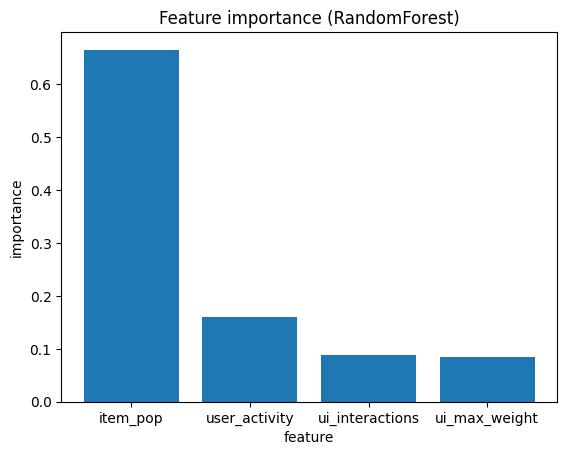

In [13]:
import matplotlib.pyplot as plt

plt.figure()
plt.bar(feat_importance["feature"], feat_importance["importance"])
plt.title("Feature importance (RandomForest)")
plt.ylabel("importance")
plt.xlabel("feature")
plt.show()


## Анализ важности признаков

В модели RandomForest были использованы 4 признака:

- `item_pop` — глобальная популярность товара;
- `user_activity` — общая активность пользователя;
- `ui_interactions` — число взаимодействий конкретной пары (user, item) в истории;
- `ui_max_weight` — максимальная "сила" взаимодействия (view / addtocart / transaction) для пары.

Оценка важности признаков показывает:

- **`item_pop` ≈ 0.66** — главный источник сигнала.  
  Модель в первую очередь опирается на популярность товара. Это хорошо согласуется
  с результатами из 06_model_comparison: popularity baseline был самым сильным
  простым подходом.

- **`user_activity` ≈ 0.16** — второй по важности признак.  
  Активные пользователи чаще совершают покупки, и модель учитывает это при ранжировании.

- **`ui_interactions` и `ui_max_weight` (по ~0.08 каждый)** — признаки истории
  конкретной пары (user, item). Они важны, но скорее как тонкая настройка:
  если у пары уже была осмысленная история взаимодействий, модель повышает
  вероятность рекомендации этого товара.

Итого, feature-based ranking явно комбинирует:

1. глобальную популярность товаров;
2. активность пользователя;
3. историю взаимодействий пары.

Именно такая комбинация даёт заметный прирост по `precision@k` и `recall@k`
по сравнению с простыми бейзлайнами и классическими CF-моделями без явных признаков.
